In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization, Input, Reshape, concatenate
import cv2
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
def visualize_images(img, num_images=5):
    total_images = len(img)
    num_rows = int(np.ceil(total_images / num_images))  # 필요한 행의 수 계산
    
    # 서브플롯 생성 (num_rows 행과 num_images 열)
    fig, axes = plt.subplots(num_rows, num_images, figsize=(num_images * 3, num_rows * 3))
    
    # 만약 num_rows가 1이라면, axes를 1차원 배열로 처리하도록 설정
    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    # 이미지 그리기
    for i in range(total_images):
        row = i // num_images  # 현재 행
        col = i % num_images  # 현재 열
        axes[row, col].imshow(img[i].squeeze(), cmap='gray')  # 이미지 표시
        axes[row, col].set_title(f"Image {i+1}")  # 이미지 제목 설정
        axes[row, col].axis('off')  # 축 숨기기
    
    # 남은 빈 서브플롯 숨기기
    for i in range(total_images, num_rows * num_images):
        row = i // num_images
        col = i % num_images
        axes[row, col].axis('off')  # 빈 칸은 숨기기
    
    plt.tight_layout()
    plt.show()

FDC 데이터 불러오기

In [4]:
df_final = pd.read_csv('./data/fdc_data.csv')

정규화

In [5]:
scaler = StandardScaler()

sensor_data = df_final.iloc[:,5:]
sensor_data_scaled = scaler.fit_transform(sensor_data)
df_sensor_scaled = pd.DataFrame(sensor_data_scaled, columns=sensor_data.columns)
df_fdc_scaled = pd.concat([df_final.iloc[:,:5].reset_index(drop=True), df_sensor_scaled.reset_index(drop=True)], axis=1)

라벨 추출

In [6]:
labels = df_fdc_scaled['PASS(1)/FAIL(0)'].values
labels = np.array(labels)

In [7]:
count_zeros = np.count_nonzero(labels == 0)
count_ones = np.count_nonzero(labels == 1)

print("0의 개수:", count_zeros)
print("1의 개수:", count_ones)

0의 개수: 363
1의 개수: 697


이미지 데이터 불러오기

In [8]:
image_data = np.load('./data/image_data.npy')

In [9]:
image_data.shape

(1060, 128, 128)

모델

1. FDC data → Image 예측

2. Image → Scratch 분류

Train / Validation / Test

In [10]:
SEED = 42

In [11]:
fdc_train, fdc_temp, img_train, img_temp, labels_train, labels_temp = train_test_split(
    df_sensor_scaled, image_data, labels, test_size=0.2, random_state=SEED
)

fdc_val, fdc_test, img_val, img_test, labels_val, labels_test = train_test_split(
    fdc_temp, img_temp, labels_temp, test_size=0.5, random_state=SEED  # 0.25 of the remaining 20% = 5% of total
)

In [12]:
fdc_train.shape, fdc_val.shape, fdc_test.shape, img_train.shape, img_val.shape, img_test.shape

((848, 216),
 (106, 216),
 (106, 216),
 (848, 128, 128),
 (106, 128, 128),
 (106, 128, 128))

평가 (기존 모델)

In [31]:
epochs = 1000

autoencoder = tf.keras.models.load_model(f'./data/model/autoencoder_model_{epochs}.keras')
classification_model = tf.keras.models.load_model(f'./data/model/cnn_model_{epochs}.keras')

# 예측에 사용할 데이터 (예: fdc_test)
fdc_test_data = fdc_test  # FDC 테스트 데이터를 준비합니다.

predicted_images = autoencoder.predict(fdc_test_data)

def predict_defect_classification(classification_model, data):
    predicted_labels = classification_model.predict(data)
    predicted_classes = (predicted_labels > 0.5).astype(int)  # 0.5 기준으로 이진 분류 (0 또는 1)
    return predicted_classes

# 예측된 Normal/Defective 클래스
predicted_classes = predict_defect_classification(classification_model, predicted_images)

# 예측 결과 출력
# visualize_images(predicted_images)

# 실제 라벨 (예: 테스트 데이터셋의 라벨)
true_labels = labels_test  # 실제 라벨이 들어있는 labels_test 변수

# 정확도 (Accuracy)
accuracy = accuracy_score(true_labels, predicted_classes)
print(f"Accuracy: {accuracy:.4f}")

# 정밀도 (Precision)
precision = precision_score(true_labels, predicted_classes, average='binary')
print(f"Precision: {precision:.4f}")

# 재현율 (Recall)
recall = recall_score(true_labels, predicted_classes, average='binary')
print(f"Recall: {recall:.4f}")

# F1 점수 (F1 Score)
f1 = f1_score(true_labels, predicted_classes, average='binary')
print(f"F1 Score: {f1:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Accuracy: 0.4057
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


c:\Users\rkdeo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error

true_images=img_test
# Generated Images의 마지막 차원 제거
generated_images_squeezed = np.squeeze(predicted_images, axis=-1)  # (53, 128, 128)

# SSIM 계산
ssim_scores = []
for i in range(len(true_images)):
    original = true_images[i]
    reconstructed = generated_images_squeezed[i]
    score = ssim(original, reconstructed, data_range=original.max() - original.min())
    ssim_scores.append(score)

# 평균 SSIM 계산
average_ssim = np.mean(ssim_scores)
print(f"Average SSIM: {average_ssim:.4f}")

mse_scores = []
for i in range(len(true_images)):
    original = true_images[i].flatten()
    reconstructed = generated_images_squeezed[i].flatten()
    score = mean_squared_error(original, reconstructed)
    mse_scores.append(score)

average_mse = np.mean(mse_scores)
print(f"Average MSE: {average_mse:.4f}")

psnr_scores = []
for i in range(len(true_images)):
    original = true_images[i]
    reconstructed = generated_images_squeezed[i]
    score = psnr(original, reconstructed, data_range=original.max() - original.min())
    psnr_scores.append(score)

average_psnr = np.mean(psnr_scores)
print(f"Average PSNR: {average_psnr:.2f} dB")


Average SSIM: 0.5629
Average MSE: 0.0157
Average PSNR: 19.85 dB


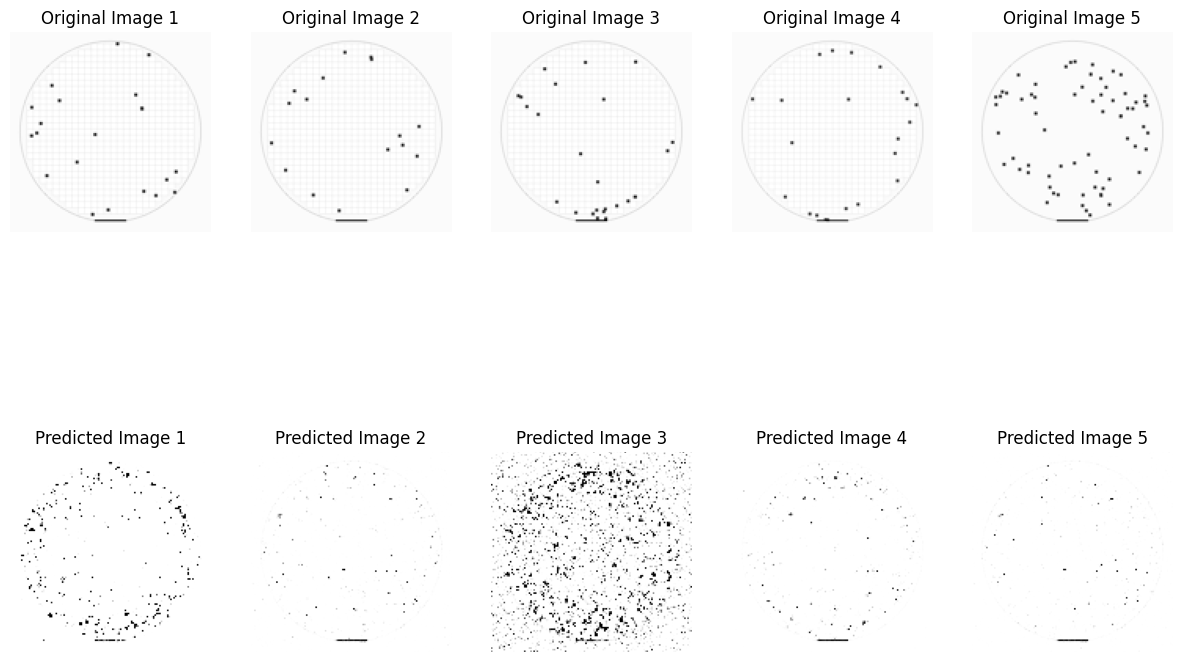

In [26]:
# 원본 이미지와 비교하여 시각적으로 평가
def compare_original_and_predicted(original_images, predicted_images):
    fig, axes = plt.subplots(2, len(original_images), figsize=(15, 10))
    
    for i in range(len(original_images)):
        # 원본 이미지 출력
        axes[0, i].imshow(original_images[i].squeeze(), cmap='gray')
        axes[0, i].set_title(f"Original Image {i+1}")
        axes[0, i].axis('off')
        
        # 예측된 이미지 출력
        axes[1, i].imshow(predicted_images[i].squeeze(), cmap='gray')
        axes[1, i].set_title(f"Predicted Image {i+1}")
        axes[1, i].axis('off')
        
       

    plt.show()

# 원본 이미지와 예측된 이미지를 비교
compare_original_and_predicted(img_test[0:5], predicted_images[0:5])

Masking

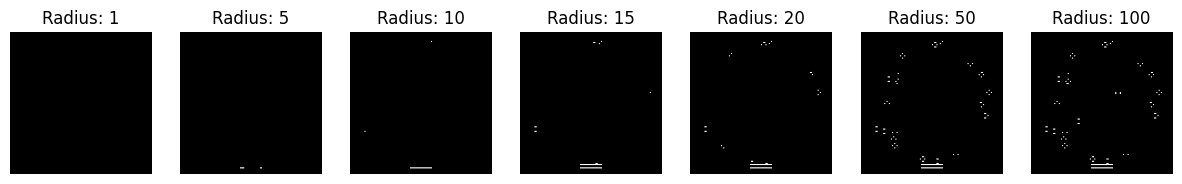

In [27]:
# 외곽 부분을 마스킹하는 함수 정의 (원형 마스크 사용)
def create_edge_mask(image, radius):
    h, w = image.shape[:2]
    center = (int(w / 2), int(h / 2))
    max_radius = min(center) - 2  # 이미지 경계 안에 들어가도록 반지름 설정
    mask = np.zeros((h, w), dtype=np.uint8)  # 마스크를 8비트 정수로 생성
    
    # 원형 마스크 생성 (두께는 외곽 영역의 범위를 조절)
    cv2.circle(mask, center, max_radius, 1, thickness=radius)  # 마스크 값 1로 설정
    return mask

# 이미지 데이터 (img_train을 불러온 상태라 가정)
image = img_train[0]  # 첫 번째 훈련 이미지 사용

# 다양한 radius 값으로 마스크를 생성하고 시각적으로 확인
radius_values = [1,5, 10, 15, 20, 50, 100]  # 다양한 반경 값을 설정
fig, axes = plt.subplots(1, len(radius_values), figsize=(15, 5))

for i, radius in enumerate(radius_values):
    # 마스크 생성
    mask = create_edge_mask(image, radius=radius)
    
    # 마스크를 이미지에 적용하여 시각적으로 비교
    masked_image = cv2.bitwise_and(image.squeeze().astype(np.uint8), image.squeeze().astype(np.uint8), mask=mask)
    
    # 이미지 출력
    axes[i].imshow(masked_image, cmap='gray')
    axes[i].set_title(f"Radius: {radius}")
    axes[i].axis('off')

plt.show()

In [28]:
# 외곽 부분을 마스킹하는 함수 정의 (원형 마스크 사용)
def create_edge_mask(image, radius=50):
    h, w = image.shape[:2]
    center = (int(w / 2), int(h / 2))
    max_radius = min(center) - 2  # 이미지 경계 안에 들어가도록 반지름 설정
    mask = np.zeros((h, w), dtype=np.uint8)  # 마스크를 uint8 형식으로 생성

    # 원형 마스크 생성 (두께는 외곽 영역의 범위를 조절)
    cv2.circle(mask, center, max_radius, 1, thickness=radius)  # 1로 채운 원형 마스크
    return mask

# 모든 이미지에 마스크 적용
def apply_mask_to_images(images, mask_radius=50):
    masked_images = []
    for image in images:
        mask = create_edge_mask(image.squeeze(), radius=mask_radius)
        
        # 이미지가 0~1로 스케일링된 경우 0~255 범위로 변환
        image_uint8 = (image.squeeze() * 255).astype(np.uint8)
        
        # 마스크 적용
        masked_image = cv2.bitwise_and(image_uint8, image_uint8, mask=mask)
        masked_images.append(masked_image)
    return np.array(masked_images)

# 훈련, 검증, 테스트 데이터 각각에 마스크 적용
masked_train = apply_mask_to_images(img_train)
masked_val = apply_mask_to_images(img_val)
masked_test = apply_mask_to_images(img_test)

In [32]:
masked_predicted_images = apply_mask_to_images(predicted_images)

# 예측된 Normal/Defective 클래스
predicted_classes = predict_defect_classification(classification_model, masked_predicted_images)

# 예측 결과 출력
# visualize_images(predicted_images)

# 실제 라벨 (예: 테스트 데이터셋의 라벨)
true_labels = labels_test  # 실제 라벨이 들어있는 labels_test 변수

# 정확도 (Accuracy)
accuracy = accuracy_score(true_labels, predicted_classes)
print(f"Accuracy: {accuracy:.4f}")

# 정밀도 (Precision)
precision = precision_score(true_labels, predicted_classes, average='binary')
print(f"Precision: {precision:.4f}")

# 재현율 (Recall)
recall = recall_score(true_labels, predicted_classes, average='binary')
print(f"Recall: {recall:.4f}")

# F1 점수 (F1 Score)
f1 = f1_score(true_labels, predicted_classes, average='binary')
print(f"F1 Score: {f1:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Accuracy: 0.4434
Precision: 0.5833
Recall: 0.2222
F1 Score: 0.3218


평가 (Concatenate 모델)

In [33]:
epochs = 1000

autoencoder = tf.keras.models.load_model(f'./data/model/autoencoder_model_{epochs}.keras')
classification_model = tf.keras.models.load_model(f'./data/model/classification_model_{epochs}.keras')

fdc_test_data = fdc_test  # FDC 테스트 데이터를 준비합니다.

predicted_images = autoencoder.predict(fdc_test_data)

def predict_defect_classification(classification_model, data):
    predicted_labels = classification_model.predict(data)
    predicted_classes = (predicted_labels > 0.5).astype(int)  # 0.5 기준으로 이진 분류 (0 또는 1)
    return predicted_classes

# 예측된 Normal/Defective 클래스
predicted_classes = predict_defect_classification(classification_model, fdc_test_data)

# 예측 결과 출력
# visualize_images(predicted_images)

# 실제 라벨 (예: 테스트 데이터셋의 라벨)
true_labels = labels_test  # 실제 라벨이 들어있는 labels_test 변수

# 정확도 (Accuracy)
accuracy = accuracy_score(true_labels, predicted_classes)
print(f"Accuracy: {accuracy:.4f}")

# 정밀도 (Precision)
precision = precision_score(true_labels, predicted_classes, average='binary')
print(f"Precision: {precision:.4f}")

# 재현율 (Recall)
recall = recall_score(true_labels, predicted_classes, average='binary')
print(f"Recall: {recall:.4f}")

# F1 점수 (F1 Score)
f1 = f1_score(true_labels, predicted_classes, average='binary')
print(f"F1 Score: {f1:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
Accuracy: 0.6509
Precision: 0.6757
Recall: 0.7937
F1 Score: 0.7299


1. FDC data → Image 예측 모델 만들기 (autoencoder 모델, 기존)

In [ ]:
# # Encoder 모델: 입력 이미지를 잠재 공간으로 압축
# def build_encoder(input_dim):
#     model = tf.keras.Sequential()
#     model.add(layers.Dense(256, input_dim=input_dim))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(512))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(1024))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(2048))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))

    
#     # 잠재 공간 (저차원 공간) 출력
#     model.add(layers.Dense(64))  # 잠재 공간의 크기를 64로 설정
    
#     return model

# # Decoder 모델: 잠재 공간에서 128x128 이미지를 복원
# def build_decoder(latent_dim):
#     model = tf.keras.Sequential()

#     model.add(layers.Dense(2048))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(1024, input_dim=latent_dim))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(512))
#     model.add(layers.LeakyReLU(alpha=0.2))
    
#     model.add(layers.Dense(256))
#     model.add(layers.LeakyReLU(alpha=0.2))
    
#     # 128x128 이미지로 복원
#     model.add(layers.Dense(128 * 128, activation='sigmoid'))  # 이미지 픽셀 값이 0-1 범위이므로 sigmoid 사용
#     model.add(layers.Reshape((128, 128, 1)))
    
#     return model

# # Autoencoder 모델: Encoder와 Decoder를 연결
# def build_autoencoder(input_dim, latent_dim):
#     encoder = build_encoder(input_dim)
#     decoder = build_decoder(latent_dim)
    
#     inputs = layers.Input(shape=(input_dim,))
#     encoded = encoder(inputs)
#     decoded = decoder(encoded)
    
#     autoencoder = tf.keras.Model(inputs, decoded)
#     autoencoder.compile(optimizer='adam', loss='mse')  # Autoencoder에서는 MSE(평균 제곱 오차)를 사용
#     return autoencoder

# # 하이퍼파라미터
# tf.random.set_seed(SEED)
# input_dim = fdc_train.shape[1]  # FDC 데이터의 차원
# latent_dim = 64  # 잠재 공간의 크기
# epochs = 1000
# batch_size = 32

# # 모델 빌드
# autoencoder = build_autoencoder(input_dim, latent_dim)

# # 학습 함수
# def train_autoencoder(epochs, batch_size):
#     autoencoder.fit(fdc_train, img_train, epochs=epochs, batch_size=batch_size, shuffle=True)

# # Autoencoder 학습 시작
# train_autoencoder(epochs, batch_size)

# # 모델 저장
# autoencoder.save(f'./data/model/autoencoder_model_{epochs}_original.keras')

2. Image 분류 모델 만들기 (CNN 모델, 기존)

In [ ]:
# # 외곽 부분을 마스킹하는 함수 정의 (원형 마스크 사용)
# def create_edge_mask(image, radius):
#     h, w = image.shape[:2]
#     center = (int(w / 2), int(h / 2))
#     max_radius = min(center) - 2  # 이미지 경계 안에 들어가도록 반지름 설정
#     mask = np.zeros((h, w), dtype=np.uint8)  # 마스크를 8비트 정수로 생성
    
#     # 원형 마스크 생성 (두께는 외곽 영역의 범위를 조절)
#     cv2.circle(mask, center, max_radius, 1, thickness=radius)  # 마스크 값 1로 설정
#     return mask

# # 이미지 데이터 (img_train을 불러온 상태라 가정)
# image = img_train[0]  # 첫 번째 훈련 이미지 사용

# # 다양한 radius 값으로 마스크를 생성하고 시각적으로 확인
# radius_values = [1,5, 10, 15, 20, 50, 100]  # 다양한 반경 값을 설정
# fig, axes = plt.subplots(1, len(radius_values), figsize=(15, 5))

# for i, radius in enumerate(radius_values):
#     # 마스크 생성
#     mask = create_edge_mask(image, radius=radius)
    
#     # 마스크를 이미지에 적용하여 시각적으로 비교
#     masked_image = cv2.bitwise_and(image.squeeze().astype(np.uint8), image.squeeze().astype(np.uint8), mask=mask)
    
#     # 이미지 출력
#     axes[i].imshow(masked_image, cmap='gray')
#     axes[i].set_title(f"Radius: {radius}")
#     axes[i].axis('off')

# plt.show()

# # 외곽 부분을 마스킹하는 함수 정의 (원형 마스크 사용)
# def create_edge_mask(image, radius=50):
#     h, w = image.shape[:2]
#     center = (int(w / 2), int(h / 2))
#     max_radius = min(center) - 2  # 이미지 경계 안에 들어가도록 반지름 설정
#     mask = np.zeros((h, w), dtype=np.uint8)  # 마스크를 uint8 형식으로 생성

#     # 원형 마스크 생성 (두께는 외곽 영역의 범위를 조절)
#     cv2.circle(mask, center, max_radius, 1, thickness=radius)  # 1로 채운 원형 마스크
#     return mask

# # 모든 이미지에 마스크 적용
# def apply_mask_to_images(images, mask_radius=50):
#     masked_images = []
#     for image in images:
#         mask = create_edge_mask(image.squeeze(), radius=mask_radius)
        
#         # 이미지가 0~1로 스케일링된 경우 0~255 범위로 변환
#         image_uint8 = (image.squeeze() * 255).astype(np.uint8)
        
#         # 마스크 적용
#         masked_image = cv2.bitwise_and(image_uint8, image_uint8, mask=mask)
#         masked_images.append(masked_image)
#     return np.array(masked_images)

# # 훈련, 검증, 테스트 데이터 각각에 마스크 적용
# masked_train = apply_mask_to_images(img_train)
# masked_val = apply_mask_to_images(img_val)
# masked_test = apply_mask_to_images(img_test)

# # CNN 모델 생성
# def build_edge_classification_model(input_shape):
#     model = models.Sequential()
    
#     # Convolutional layer로 특징 추출
#     model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))
    
#     # Flatten하여 Dense Layer에 연결
#     model.add(layers.Flatten())
#     model.add(layers.Dense(128, activation='relu'))
    
#     # 이진 분류를 위한 출력층
#     model.add(layers.Dense(1, activation='sigmoid'))  # 이진 분류
    
#     # 모델 컴파일
#     model.compile(optimizer='adam',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
    
#     return model

# # 입력 이미지의 크기 (128x128 크기의 흑백 이미지)
# input_shape = (128, 128, 1)
# cnn = build_edge_classification_model(input_shape)

# epochs = 1000

# # 훈련 데이터를 이용해 모델 학습
# cnn.fit(masked_train, labels_train, 
#           epochs=epochs, 
#           batch_size=32, 
#           validation_data=(masked_val, labels_val))

# # 모델 저장
# cnn.save(f'./data/model/cnn_model_{epochs}.keras')

3. Concatenate 모델 만들기

In [ ]:
# # Encoder 모델: 입력 Tabular 데이터를 잠재 공간으로 압축
# def build_encoder(input_dim):
#     model = tf.keras.Sequential()
#     model.add(layers.Dense(256, input_dim=input_dim))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(512))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(1024))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(2048))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))

#     # 잠재 공간 출력
#     model.add(layers.Dense(64))  # 잠재 공간의 크기를 64로 설정
    
#     return model

# # Decoder 모델: 잠재 공간에서 128x128 이미지를 복원
# def build_decoder(latent_dim):
#     model = tf.keras.Sequential()

#     model.add(layers.Dense(2048, input_dim=latent_dim))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(1024))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(512))
#     model.add(layers.LeakyReLU(alpha=0.2))
    
#     model.add(layers.Dense(256))
#     model.add(layers.LeakyReLU(alpha=0.2))
    
#     # 128x128 이미지로 복원
#     model.add(layers.Dense(128 * 128, activation='sigmoid'))
#     model.add(layers.Reshape((128, 128, 1)))
    
#     return model

# # Autoencoder 모델: Encoder와 Decoder를 연결
# def build_autoencoder(input_dim, latent_dim):
#     encoder = build_encoder(input_dim)
#     decoder = build_decoder(latent_dim)
    
#     inputs = layers.Input(shape=(input_dim,))
#     encoded = encoder(inputs)
#     decoded = decoder(encoded)
    
#     autoencoder = tf.keras.Model(inputs, decoded)
#     autoencoder.compile(optimizer='adam', loss='mse')
#     return autoencoder

# def build_classification_model(input_dim, latent_dim):
#     autoencoder = build_autoencoder(input_dim, latent_dim)
   
#     # Tabular 데이터를 위한 입력
#     tabular_input = layers.Input(shape=(input_dim,))
#     # AutoEncoder로 생성된 이미지
#     decoded_image = autoencoder(tabular_input)
    
#     # 분류 목적의 새로운 피처 추출 레이어 추가
#     feature_extraction = layers.Dense(512, activation='relu')(tabular_input)
#     feature_extraction = layers.BatchNormalization()(feature_extraction)
#     feature_extraction = layers.Dense(256, activation='relu')(feature_extraction)
#     feature_extraction = layers.BatchNormalization()(feature_extraction)
    
#     # AutoEncoder 이미지와 새로운 피처 추출 레이어를 결합
#     flat_image = layers.Flatten()(decoded_image)
#     concat_features = layers.concatenate([feature_extraction, flat_image])
    
#     # Classification Layer
#     x = layers.Dense(512, activation='relu')(concat_features)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dense(256, activation='relu')(x)
#     x = layers.BatchNormalization()(x)
    
#     output = layers.Dense(1, activation='sigmoid')(x)  # 이진 분류를 가정
    
#     model = tf.keras.Model(inputs=tabular_input, outputs=output)
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
#     return model, autoencoder

# # 하이퍼파라미터
# tf.random.set_seed(SEED)
# input_dim = fdc_train.shape[1]  # FDC 데이터의 차원
# latent_dim = 64  # 잠재 공간의 크기
# epochs = 1000
# batch_size = 32

# # 모델 빌드 및 학습
# classification_model, autoencoder = build_classification_model(input_dim, latent_dim)

# # AutoEncoder 학습
# autoencoder.fit(fdc_train, img_train, epochs=epochs, batch_size=batch_size, shuffle=True)

# # 분류 모델 학습
# classification_model.fit(fdc_train, labels_train, epochs=epochs, batch_size=batch_size, shuffle=True)

# # 모델 저장
# autoencoder.save(f'./data/model/autoencoder_model_{epochs}.keras')
# classification_model.save(f'./data/model/classification_model_{epochs}.keras')